# INM707: Basic Tasks

We define an environment where a robot vacuum cleaner navigates through a single-story house, trying to clean the carpets of the house. It needs to furniture, walls, and cables/wires, whilst trying to clean the carpets in the shortest time possible.

The work presented here is part of the coursework of the INM707 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM707).

### Import Libraries

We use NumPy for most of the class and environment creation. Matplotlib is used for visualising the environment and for generating any plots.

In [1]:
# Import Relevant Libraries
import numpy as np
import random
import matplotlib.pyplot as plt

### Set Random Seed

In order to reproduce the results every time we run the notebook, we set a random seed.

In [2]:
randomer = 50

# Random Seed
random.seed(randomer)
np.random.seed(randomer)

### Function to Visualise the Environment

It is important to visualise our environment to see that it is correctly designed. We define a class that does this below. The class is heavily modified, but is based on a class by lecturers at Imperial College London: https://github.com/LorenzoStigliano/imperial-reinforcement-learning/blob/master/Coursework/CW1/coursework_1_maze.ipynb.

In [3]:
# Class for visualising the environment, not strictly necessary but useful to see whether the environment is correctly designed
class Visualiser(object):
    """
    Class to visualise our (Gridworld) environment. We visualise our robot vacuum cleaner environment using this class.
    It requires hyperparameters to be input, which are the grid size (shape), all locations, locations of any obstacles (cables), locations of any walls/furniture, locations of any extra reward locations (carpets),
    locations of terminal states (absorbing states), the reward obtained from visiting these terminal states, and the default reward for taking an action.
    
    The class is inspired and based on the coursework from a Reinforcement Learning module at Imperial College London, which was given to students to help with their assignments.
    That class can be found here: https://github.com/LorenzoStigliano/imperial-reinforcement-learning/blob/master/Coursework/CW1/coursework_1_maze.ipynb.
    """
    # Initialise Visualiser object (to visualise the environment)
    def __init__(self, shape, locations, colour, obstacle_locs, wall_locs, non_terminal_reward_locs, terminal_locs, terminal_rewards, terminal):
        # Define variables for use within the object
        self.shape = shape
        self.locations = locations
        self.terminal = terminal

        # Set up the environment components
        
        # Obstacles/Cables (can be visited, but gives negative reward)
        self.obstacles = np.zeros(self.shape)
        # Set obstacle locations with penalty (colour choice, not related to actual reward)
        for ob in obstacle_locs:
            self.obstacles[ob] = 25

        # Walls/Furniture (states that cannot be visited)
        self.walls = np.zeros(self.shape)
        # Set wall/furniture locations with penalty (colour choice, not related to actual reward)
        for wall in wall_locs:
            self.walls[wall] = 5

        # Non-Terminal Rewards (can be visited and gives positive reward)
        self.non_terminal_rewards = np.zeros(self.shape)
        # Set extra reward locations with reward (colour choice, not related to actual reward)
        for reward in non_terminal_reward_locs:
            self.non_terminal_rewards[reward] = 15
        
        # Terminal Rewards (can be visited and ends the episode)
        self.rewarders = np.ones(self.shape) * colour
        # Set terminal locations with reward (colour choice, not related to actual reward)
        for i, rew in enumerate(terminal_locs):
            self.rewarders[rew] = 10 if terminal_rewards[i] > 0 else -10

        # Print the map to show it
        self.paint_maps()

    # Method to visualise the environment
    def paint_maps(self):
        # Plot the environment with obstacles, walls, rewards, and terminal states
        plt.figure(figsize = (10, 5))
        # Create the graph of the Gridworld
        plt.imshow(self.obstacles + self.walls + self.rewarders + self.non_terminal_rewards)
        # Save Gridworld as a .pdf file
        plt.savefig("gridworld.pdf")
        plt.show()

    # Method to visualise the environment with a specific state highlighted
    def paint_state(self, state):
        # Plot the environment with the state highlighted
        states = np.zeros(self.shape)
        states[state] = 30
        plt.figure(figsize = (10, 5))
        # Create the graph of the Gridworld
        plt.imshow(self.obstacles + self.walls + self.rewarders + self.non_terminal_rewards + states)
        plt.show()

    # Method to draw the deterministic policy on the environment
    def draw_deterministic_policy(self, Policy):
        # Plot the environment with deterministic policy arrows overlaid
        plt.figure(figsize = (10, 5))
        # Create the graph of the Gridworld
        plt.imshow(self.obstacles + self.walls + self.rewarders + self.non_terminal_rewards)
        for state, action in enumerate(Policy):
            # If it is an terminal state, do not plot any action
            if(self.terminal[0, state]):
                continue
            # List of arrows corresponding to each possible action
            arrows = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            # Take the corresponding action
            action_arrow = arrows[action]
            # Compute its location on graph
            location = self.locations[state]
            # Place it on graph
            plt.text(location[1], location[0], action_arrow, color = "red", ha = "center", va = "center")
        plt.savefig("policy_drawn.pdf")
        plt.show()

    # Method to draw the optimal policy on the environment
    def draw_policy(self, Policy):
        # Plot the environment with optimal policy arrows overlaid
        deterministic_policy = np.array([np.argmax(Policy[row, :]) for row in range(Policy.shape[0])])
        self.draw_deterministic_policy(deterministic_policy)

    # Method to draw the state values on the environment
    def draw_value(self, Value):
        # Plot the environment with state values overlaid
        plt.figure(figsize = (10, 5))
        # Create the graph of the Gridworld
        plt.imshow(self.obstacles + self.walls + self.rewarders + self.non_terminal_rewards)
        for state, value in enumerate(Value):
            # If it is an terminal state, do not plot any value
            if(self.terminal[0, state]):
                continue
            # Compute the value location on graph
            location = self.locations[state]
            # Place it on graph
            plt.text(location[1], location[0], round(value, 2), color = "red", ha = "center", va = "center")
        plt.savefig("value_drawn.pdf")
        plt.show()

    # Method to draw a grid of environments with deterministic policies overlaid
    def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
        # Plot a grid of environments with deterministic policies overlaid
        plt.figure(figsize = (20, 8))
        # Go through all policies
        for subplot in range (len(Policies)):
            # Create a subplot for each policy
            ax = plt.subplot(n_columns, n_lines, subplot + 1)
            # Create the graph of the Gridworld
            ax.imshow(self.obstacles + self.walls + self.rewarders + self.non_terminal_rewards)
            for state, action in enumerate(Policies[subplot]):
                # If it is an terminal state, do not plot any action
                if(self.terminal[0,state]):
                    continue
                # List of arrows corresponding to each possible action
                arrows = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
                # Take the corresponding action
                action_arrow = arrows[action]
                # Compute its location on graph
                location = self.locations[state]
                # Place it on graph
                plt.text(location[1], location[0], action_arrow, ha = "center", va = "center")
            # Set the title for the graph given as argument
            ax.title.set_text(title[subplot])
        plt.show()

    # Method to draw a grid of environments with optimal policies overlaid
    def draw_policy_grid(self, Policies, title, n_columns, n_lines):
        # Plot a grid of environments with optimal policies overlaid
        deterministic_policies = np.array([[np.argmax(Policy[row, :]) for row in range(Policy.shape[0])] for Policy in Policies])
        self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

    # Method to draw a grid of environments with state values overlaid
    def draw_value_grid(self, Values, title, n_columns, n_lines):
        # Plot a grid of environments with state values overlaid
        plt.figure(figsize = (20, 8))
        # Go through all values
        for subplot in range (len(Values)):
            # Create a subplot for each value
            ax = plt.subplot(n_columns, n_lines, subplot + 1)
            # Create the graph of the Gridworld
            ax.imshow(self.obstacles + self.walls + self.rewarders + self.non_terminal_rewards)
            for state, value in enumerate(Values[subplot]):
                # If it is an terminal state, do not plot any value
                if(self.terminal[0, state]):
                    continue
                # Compute the value location on graph
                location = self.locations[state]
                # Place it on graph
                plt.text(location[1], location[0], round(value, 1), ha = "center", va = "center")
            # Set the title for the graoh given as argument
            ax.title.set_text(title[subplot])
        plt.show()

### Environment Creation

We need a class that allows us to create our environment. It also needs to allow for visualisation, and can be found below. The class is heavily modified, but is based on a class by lecturers at Imperial College London: https://github.com/LorenzoStigliano/imperial-reinforcement-learning/blob/master/Coursework/CW1/coursework_1_maze.ipynb.

In [4]:
class Gridworld(object):
    """
    Class to create an environment, which is normally referred to as a Gridworld. We construct our robot vacuum cleaner environment using this class.
    It requires hyperparameters to be input, which are the grid size (shape), locations of any obstacles, locations of any walls, locations of terminal states (absorbing states),
    the reward obtained from visiting these terminal states, possible starting locations of the agent, the default reward for taking an action, and finally
    the maximum number of steps the agent can take before the episode ends.
    
    The class is inspired and based on the coursework from a Reinforcement Learning module at Imperial College London, which was given to students to help with their assignments.
    That class can be found here: https://github.com/LorenzoStigliano/imperial-reinforcement-learning/blob/master/Coursework/CW1/coursework_1_maze.ipynb.
    """
    # Initialise Gridworld object (to create the environment)
    def __init__(self, shape, obstacle_locs, wall_locs, non_terminal_reward_locs, terminal_locs, terminal_rewards, starting_locs, colour, max_time):
        # Define variables for use within the object
        self._shape = shape
        self._obstacle_locs = obstacle_locs
        self._wall_locs = wall_locs
        self._non_terminal_reward_locs = non_terminal_reward_locs
        self._terminal_locs = terminal_locs
        self._terminal_rewards = terminal_rewards
        self._starting_locs = starting_locs
        self._colour = colour
        self._max_time = max_time
        
        # Build the environment
        self._build_Gridworld()

    # Method to build the Gridworld environment
    def _build_Gridworld(self):
        # Four total actions
        self._action_size = 4
        # Up, right, down, left (North, East, South, West)
        self._direction_names = ["N", "E", "S", "W"]
        self._locations = []

        # Populate list of locations based on grid size and obstacle placements
        for i in range(self._shape[0]):
            for j in range(self._shape[1]):
                loc = (i, j)
                if self._is_location(loc):
                    # Adding the state to locations
                    self._locations.append(loc)

        # Number of locations
        self._state_size = len(self._locations)

        # Each line is a state, with each column a unique action/direction (N, E, S, W)
        self._neighbours = np.zeros((self._state_size, 4)) 

        # Loop over states
        for state in range(self._state_size):
            # Get location of state on grid
            loc = self._get_loc_from_state(state)

            # Moving North
            neighbour = (loc[0] - 1, loc[1])
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("N")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("N")] = state

            # Moving East
            neighbour = (loc[0], loc[1] + 1)
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("E")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("E")] = state

            # Moving South
            neighbour = (loc[0] + 1, loc[1])
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("S")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("S")] = state
            
            # Moving West
            neighbour = (loc[0], loc[1] - 1)
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("W")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("W")] = state

        # Terminal states
        self._terminal = np.zeros((1, self._state_size))
        for a in self._terminal_locs:
            terminal_state = self._get_state_from_loc(a)
            self._terminal[0, terminal_state] = 1

        # Construct transition matrix
        self._T = np.zeros((self._state_size, self._state_size, self._action_size))
        # Loop over every action/direction
        for action in range(self._action_size):
            for outcome in range(4):
                if action == outcome:
                    prob = 1
                else:
                    prob = 0
                for prior_state in range(self._state_size):
                    if not self._terminal[0, prior_state]:
                        post_state = self._neighbours[prior_state, outcome]
                        post_state = int(post_state)
                        self._T[prior_state, post_state, action] += prob

        # Construct reward matrix
        self._construct_R()
        
        # Create visualiser for the Gridworld environment
        self._graphics = Visualiser(self._shape, self._locations, self._colour, self._obstacle_locs, self._wall_locs, self._non_terminal_reward_locs, self._terminal_locs, self._terminal_rewards, self._terminal)
        # Reset the environment
        self.reset()

    # Method to check if a location is valid (reachable)
    def _is_location(self, loc):
        if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0] - 1 or loc[1] > self._shape[1] - 1):
            return False
        elif (loc in self._obstacle_locs):
            return True
        elif (loc in self._wall_locs):
            return False
        elif (loc in self._non_terminal_reward_locs):
            return True
        else:
            return True

    # Method to construct the reward matrix
    def _construct_R(self):
        # Reward matrix
        # Fill matrix with zeroes
        self._R = np.zeros((self._state_size, self._state_size, self._action_size))
        # Assign rewards of terminal states
        for i in range(len(self._terminal_rewards)):
            post_state = self._get_state_from_loc(self._terminal_locs[i])
            # Assign reward for visiting terminal state
            self._R[:, post_state, :] = self._terminal_rewards[i]

        # Assign negative reward for moving into obstacles (cables)
        for obstacle_loc in self._obstacle_locs:
            obstacle_state = self._get_state_from_loc(obstacle_loc)
            # Negative reward for all actions leading to an obstacle
            self._R[:, obstacle_state, :] = -100
            # Negative reward for moving from obstacle state to itself
            self._R[obstacle_state, obstacle_state, :] = -100

        # Get non-obstacle locations and non-terminal locations
        self._normal_locs = [(i, j) for i in range(self._shape[0]) for j in range(self._shape[1]) if (i, j) not in self._obstacle_locs and (i, j) not in self._wall_locs and (i, j) not in self._non_terminal_reward_locs and not self._terminal[0, self._get_state_from_loc((i, j))]]

        # Assign reward for moving to a non-obstacle (some areas not used)
        for normal_loc in self._normal_locs:
            normal_state = self._get_state_from_loc(normal_loc)
            # Positive reward for all actions leading to a new location
            #self._R[:, normal_state, :] = 0
            # Negative reward for moving to itself (the agent tried to move off the grid or to a wall/furniture location)
            self._R[normal_state, normal_state, :] = -100

        # Assign positive reward for moving to a carpet (all of them are initially not cleaned)
        for non_terminal_reward_loc in self._non_terminal_reward_locs:
            non_terminal_reward_loc_state = self._get_state_from_loc(non_terminal_reward_loc)
            # Positive reward for all actions leading to a new non-cleaned location
            self._R[:, non_terminal_reward_loc_state, :] = 50
            # Negative reward for moving to itself (the agent tried to move off the grid or to a wall/furniture location)
            self._R[non_terminal_reward_loc_state, non_terminal_reward_loc_state, :] = -100
        
        # Save reward matrix in memory, as it will be changed later during the episode
        self._R_old = self._R
        return self._R_old, self._R

    # Method to get state index from location
    def _get_state_from_loc(self, loc):
        return self._locations.index(tuple(loc))

    # Method to get location from state index
    def _get_loc_from_state(self, state):
        return self._locations[state]

    # Method to return the state transition matrix
    def get_T(self):
        return self._T

    # Method to return the reward matrix
    def get_R(self):
        return self._R

    # Method to return terminal state indicators
    def get_terminal(self):
        return self._terminal

    # Method to return the visualiser object
    def get_graphics(self):
        return self._graphics

    # Method to return the action size
    def get_action_size(self):
        return self._action_size

    # Method to return the state size
    def get_state_size(self):
        return self._state_size

    # Method to reset the environment
    def reset(self):
        # Define/reset variables for use within the object (during agent training)
        self._t = 0
        self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
        self._reward = 0
        self._R = self._construct_R()[0]
        self._done = False
        self._visited = set()
        self._visited.add(self._state)
        self._visited_carpets = set()
        return self._t, self._state, self._reward, self._done

    # Method to take a step in the environment
    def step(self, action):
        if self._done:
            print("Please reset the environment")
            return self._t, self._state, self._reward, self._done
        
        # Determine the next state based on the action taken
        new_state = np.argmax(self._T[self._state, :, action])

        self._reward = self._R[self._state, new_state, action]
        
        # Adjust reward matrix if new state reached
        obstacle_locations = [obstacle_state for obstacle_state in list(map(self._get_state_from_loc, self._obstacle_locs))]
        non_terminal_reward_locations = [non_terminal_reward for non_terminal_reward in list(map(self._get_state_from_loc, self._non_terminal_reward_locs))]

        # If the new state is one of the extra reward locations ('non_terminal_reward_locations')
        if new_state in non_terminal_reward_locations:
            # Check if the carpet has been visited before
            if new_state not in self._visited_carpets:
                self._visited_carpets.add(new_state)  # Add the carpet location to the set of visited carpets
                self._R[:, new_state, :] = 0
            else:
                self._reward = 0  # If the carpet has been visited before, set the reward to zero

            self._visited.add(new_state)

        # Negative reward per time point
        self._reward += -0.1
        
        # Setting new t, state and done
        self._t += 1
        self._done = self._terminal[0, new_state] or self._t > self._max_time
        self._state = new_state
        
        return self._t, self._state, self._reward, self._done

### Environment Hyperparameters

Now that we have created our environment classes, we can actually start to create our environment. We define the parameters for our environment below. We have a 6x6 grid, 3 obstacle locations, 14 wall/furniture locations, 1 terminal location, and 1 starting location at (5, 5). The maximum number of steps in our environment that the agent can take is 500.

In [5]:
# Define environment hyperparameters, see report for more detail
shape = (6, 6)
obstacle_locs = [(2, 3), (3, 5), (4, 0)]
wall_locs = [(0, 0), (0, 2), (0, 3), (0, 5), (1, 2), (1, 5), (2, 2), (2, 5), (4, 2), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3)]
non_terminal_reward_locs = [(2, 0), (4, 3)]
terminal_locs = [(0, 1)]
terminal_rewards = [60]
starting_locs = [(5, 5)]
colour = -20
max_time = 500

### Defining and Visualising the Environment

The yellow location represents the terminal/absorbing state, of which there is only one at (row=0, col=1). The robot should ultimately try to go here so it can recharge its battery after cleaning the floors. The light purple locations (such as the one in (0, 0)) represent walls/furniture (both are referred to as walls in the code), of which there are 14. The green locations represent cables/wires, which are states that provide negative reward, and there are 3. The blue-green locations (such as the one in (2, 0)) represent carpets, which the robot needs to clean. Lastly, the purple locations represent the floors that the robot can use to navigate the house, and the robot can safely visit these locations (16 in total). Details of all of these can be found in the report.

Robot Vacuum Cleaner Environment:



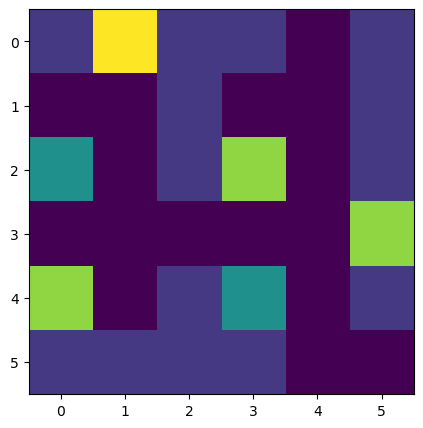

CPU times: total: 62.5 ms
Wall time: 396 ms


In [6]:
%%time
# Create robot vacuum cleaner environment
print("Robot Vacuum Cleaner Environment:\n")
vacuum_environment = Gridworld(shape = shape, obstacle_locs = obstacle_locs, wall_locs = wall_locs, non_terminal_reward_locs = non_terminal_reward_locs, terminal_locs = terminal_locs, terminal_rewards = terminal_rewards, starting_locs = starting_locs, colour = colour, max_time = max_time)

### Transition and Reward Matrices

A Markov decision process requires a state-transition matrix and a reward matrix. We display these below, as well as the possible transition probabilities (0 or 1), and the possible reward values (-100, 0, 50 or 60).

In [7]:
# Transition Matrix
print("Possible Transition Probabilities:", np.unique(vacuum_environment.get_T()))
print("Transition Matrix:\n", vacuum_environment.get_T())

# Reward Matrix (note that the reward for visiting a previous state changes during the episode)
print("Possible Reward Values:", np.unique(vacuum_environment.get_R()))
print("Initial Reward Matrix:\n", vacuum_environment.get_R())

Possible Transition Probabilities: [0. 1.]
Transition Matrix:
 [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [1. 1. 0. 1.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 0. 0. 1.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [0. 0. 1. 1.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 1.]
  [1. 1. 1. 0.]]]
Possible Reward Values: [-100.    0.   50.   60.]
Initial Reward Matrix:
 [[[  60.   60.   60.   60.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  ...
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]]

 [[  60.   60.   60.   60.]
  [-100. -100. -100. -100.]
 

### Q-learning Algorithm

Q-learning is a model-free algorithm that is commonly used in reinforcement learning to find the optimal action-selection policy for a given Markov decision process. We create a class for the algorithm, allowing for the $\epsilon$-greedy, upper confidence bound, and standard greedy policies to be used. The agent can be trained on the environment using the .train() function, and the policy after training can be evaluated using .evaluate().

In [8]:
class Q_Learner(object):
    """
    Class for the Q-learning algorithm. It requires an environment to run, such as our Gridworld (robot vacuum cleaner) environment.
    It allows for the epsilon-greedy policy to be used, a standard greedy policy, the upper confidence bound policy, an agent to be trained on the environment through Q-learning,
    and for the agent to be evaluated after training (running the final trained Q-table on many episodes, and taking the mean and standard deviation
    of the final reward in each episode).
    """
    # Epsilon-Greedy Policy
    def epsilon_greedy(self, env, Q_table, s, epsilon = 0.7):
        # Get size of action space
        action_size = env.get_action_size()
        # Get possible actions
        actions = [action for action in range(action_size)]
        # Find optimal action
        optimal_action = np.argmax(Q_table[s, :])
        # Get single random number (could use random.uniform(0, 1))
        random_int = np.random.rand(1)[0]

        # Return the optimal action if random number is greater than or equal to epsilon
        if random_int >= epsilon:
            return optimal_action
        # Return a random action, not the optimal action, if random number is less than epsilon
        else:
            other_actions = [a for a in actions if a != optimal_action]
            return np.random.choice(other_actions)

    # Simple Greedy Policy
    def get_greedy_policy(self, env, Q_table, policy):
        states = env.get_state_size()
        # Find the optimal action in each state
        for s in range(states):
            optimal_action = np.argmax(Q_table[s, :])
            policy[s, optimal_action] = 1
        return policy

    # Upper Confidence Bound Policy
    def upper_confidence_bound(self, env, Q_table, s, t, const = 1):
        # Upper Confidence Bound action selection
        action_size = env.get_action_size()
        actions = [action for action in range(action_size)]

        # Get Upper Confidence Bound
        ucb_values = Q_table[s, :] + const * np.sqrt(np.log(t + 1) / (np.sum(Q_table[s, :] > 0) + 1e-6))
        return np.argmax(ucb_values)

    # Softmax Policy
    def softmax_boltzmann(self, env, Q_table, s, tau):
        # Softmax action selection (Boltzmann exploration)
        action_values = Q_table[s, :]
    
        # Subtract the maximum action-value to prevent overflow
        max_value = np.max(action_values)
        shifted_values = action_values - max_value
    
        # Compute the log-sum-exp of the shifted action-values
        logsumexp = np.log(np.sum(np.exp(shifted_values / tau)))
    
        # Compute the exponentiated action-values
        exp_values = np.exp(shifted_values / tau - logsumexp)
    
        # Normalise to obtain action probabilities
        action_probs = exp_values / np.sum(exp_values)
    
        # Choose an action based on the computed probabilities
        return np.random.choice(len(action_probs))

    # Train the agent
    def train(self, env, Q_table, total_episodes = 10000, min_epsilon = 0.15, max_epsilon = 0.9, decay_rate = 0.0005, gamma = 0.8, alpha = 0.6, const = 1, tau = 1, policy = "epsilon-greedy"):
        # Define lists for logging statistics
        episode_rewards = []
        avg_change_in_Q = []
        time_stamps = []
        final_values = [np.zeros(env.get_state_size())]

        old_Q_table = Q_table
        
        for episode in range(total_episodes):
            # Epsilon Decay (if epsilon is used in the policy)
            epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(- decay_rate * episode)
            # Tau Decay (if tau is used in the policy)
            tau = tau * np.exp(-decay_rate * episode) + 0.0001
            rewards = 0
            V = final_values[-1].copy()
            # Reset the environment
            t, s_t, reward_, done_ = env.reset()

            # Repeat until the episode ends or time runs out
            while not done_:
                # Choose between the Upper Confidence Bound policy, Epsilon-Greedy policy or Softmax policy
                if policy == "ucb":
                    a_t = self.upper_confidence_bound(env, Q_table, s_t, t, const)
                elif policy == "epsilon-greedy":
                    a_t = self.epsilon_greedy(env, Q_table, s_t, epsilon)
                elif policy == "softmax":
                    a_t = self.softmax_boltzmann(env, Q_table, s_t, tau)
                    
                t, s_t_1, r_t_1, done_ = env.step(a_t)

                # Update the Q-matrix using the update rule
                Q_table[s_t, a_t] += alpha * (r_t_1 + gamma * max(Q_table[s_t_1, :]) - Q_table[s_t, a_t])
                V[s_t] += alpha * (r_t_1 + gamma * V[s_t_1] - V[s_t])

                # Update reward and new state
                rewards += r_t_1
                s_t = s_t_1

            # Calculate average change in Q-matrix for this episode
            avg_change = np.mean(np.abs(Q_table - old_Q_table))
            avg_change_in_Q.append(avg_change)

            # Update 'old_Q_table' for the next episode
            old_Q_table = Q_table.copy()
            
            # Append statistics to their relevant lists
            episode_rewards.append(rewards)
            time_stamps.append(t)
            final_values.append(V)

        # Gather the final greedy policy
        final_policy = np.zeros((env.get_state_size(), env.get_action_size()))
        final_policy = self.get_greedy_policy(env, Q_table, final_policy)
      
        return final_policy, final_values, episode_rewards, time_stamps, avg_change_in_Q, Q_table

    # Evaluate the agent's optimal policy
    def evaluate(self, env, Q_table, total_episodes):
        # Define list to log the reward after each episode
        episode_rewards = []
        # For every episode
        for episode in range(total_episodes):
            # Reset the environment
            t_, s_t, reward_, done_ = env.reset()
            rewards = 0

            # Repeat until the episode ends or time runs out
            while not done_:
                # Get optimal action
                a_t = np.argmax(Q_table[s_t, :])
                t, s_t_1, r_t_1, done_ = env.step(a_t)

                # Update reward and new state
                rewards += r_t_1
                s_t = s_t_1

            # Append reward during the episode to list
            episode_rewards.append(rewards)

        # Take mean and standard deviation of logged rewards
        mean_reward = np.mean(episode_rewards)
        std_reward = np.std(episode_rewards)
      
        return mean_reward, std_reward, episode_rewards

### Initial Q-learning Hyperparameters

The Q-learning algorithm requires two parameters to be set, $\alpha$ and $\gamma$. $\alpha$ is the learning rate, which determines the usefulness of new information. $\gamma$ is the discount rate, which determines the importance of getting higher reward in the long-term.

In fully deterministic environments, it is known that $\alpha = 1$ is optimal.

Our initial parameters for Q-learning are:

$\alpha$: 1.0,
$\gamma$: 0.8.

The $\epsilon$-greedy policy is commonly used in exploration-exploitation problems, and decides with probability $\epsilon$ whether or not to explore new actions/states or to exploit the knowledge of the actions/states the agent currently has.

Our initial parameters for our $\epsilon$-greedy policy are:

Max $\epsilon$: 0.9,
Min $\epsilon$: 0,
Decay Rate: 0.0005

$\epsilon$ in the $\epsilon$-greedy policy decays every episode through the following equation:

$$\epsilon \leftarrow \{\text{Min } \epsilon\} + (\{\text{Max } \epsilon\} - \{\text{Min } \epsilon\}) \cdot e^{(- \text{\{Decay Rate\}} \cdot \text{{ Episode Number}\}})}$$

In [9]:
# Q-learning parameters
alpha = 1.0
gamma = 0.8
total_episodes = 10000

# Exploration-Exploitation parameters (Epsilon-Greedy, with Epsilon decay)
policy = "epsilon-greedy"
max_epsilon = 0.9
min_epsilon = 0
decay_rate = 0.0005

# Set Initial Q-table (we use zeroes, but random numbers from a uniform [0, 1) distribution work too)
Q_table = np.zeros((vacuum_environment.get_state_size(), vacuum_environment.get_action_size()))

### Initial Results

We can now run the Q-learning algorithm using our chosen initial parameters. We also display the policy and value overlay visualisation over the environment.

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

Q-learning Final Policy and Policy Values:



findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.


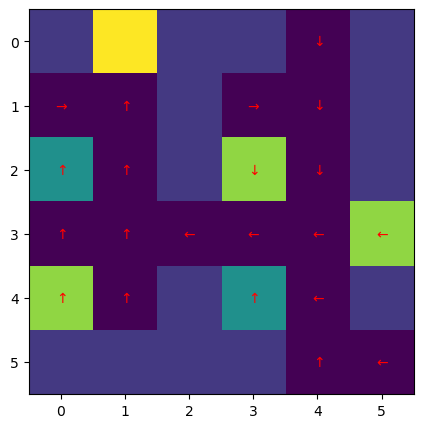

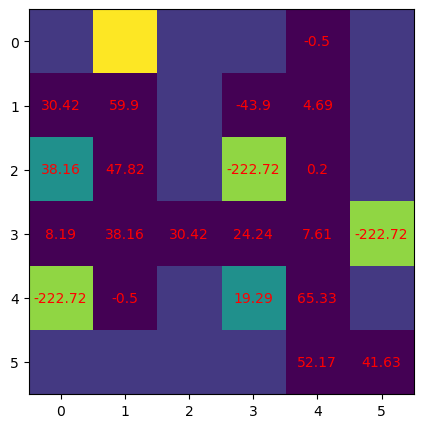

CPU times: total: 4.95 s
Wall time: 13.6 s


In [10]:
%%time
# Set seed again (if needed)
np.random.seed(randomer)
random.seed(randomer)

# Create class object for Q-learning
initial_q_learning = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = initial_q_learning.train(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = max_epsilon, decay_rate = decay_rate, gamma = gamma, alpha = alpha, policy = policy)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment.get_graphics().draw_policy(final_policy)
vacuum_environment.get_graphics().draw_value(final_values[-1])

### Evaluate Initial Results

Using our initial parameters, we obtain a sub-optimal policy after 10000 episodes (see the drawn policy overlay). The agent fails to reach the carpet at (2, 0), but reaches the terminal state and the carpet at (4, 3).

We can display the final reward after each episode and the number of steps during that episode as a plot, sharing the same x-axis. There is clear convergence to the sub-optimal policy. The agent evaluation also explains a mean reward of 109.0999 and standard deviation of 1.421085e-14 (or zero) on 10000 episodes (after agent training). The agent begins at the same state and follows the same policy, so the standard deviation is to be expected.

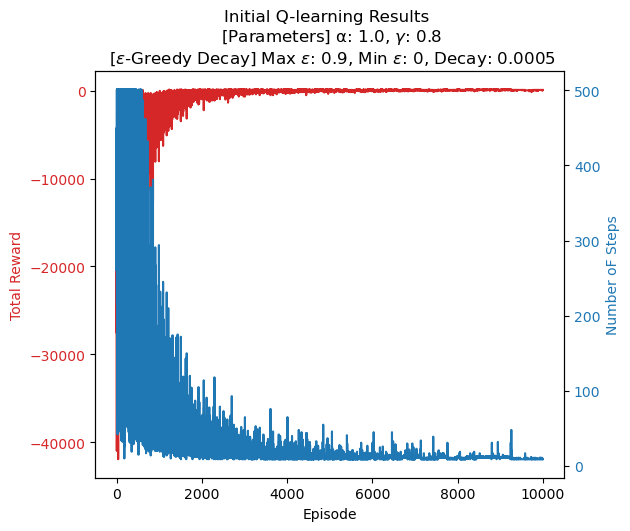

In [11]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color = "tab:red")
ax1.plot(total_rewards, color = "tab:red")
ax1.tick_params(axis = "y", labelcolor = "tab:red")

ax2 = ax1.twinx()

ax2.set_ylabel("Number oF Steps", color = "tab:blue")
ax2.plot(time_stamps, color = "tab:blue")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

fig.tight_layout()

plt.title(f"Initial Q-learning Results \n [Parameters] α: {alpha}, $\gamma$: {gamma} \n [$\epsilon$-Greedy Decay] Max $\epsilon$: {max_epsilon}, Min $\epsilon$: {min_epsilon}, Decay: {decay_rate}")
plt.savefig("initial_q_combined.pdf", bbox_inches = "tight")
plt.show()

In [12]:
%%time
# Gather statistics of agent evaluation (for final policy)
mean_reward, std_reward, episode_rewards = initial_q_learning.evaluate(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: 109.09999999999998
Standard Deviation of Episode Rewards: 1.4210854715202004e-14
CPU times: total: 750 ms
Wall time: 2.19 s


### Exploring Different Parameters 1 ($\epsilon$-Greedy)

We experiment with different parameters for the Q-learning algorithm and policy.

Let us now try $\gamma = 0.9$, while keeping the other parameters the same.

In [13]:
# Q-learning parameters
alpha = 1.0
gamma = 0.9
total_episodes = 10000

# Exploration-Exploitation parameters (Epsilon-Greedy, with Epsilon decay)
policy = "epsilon-greedy"
max_epsilon = 0.9
min_epsilon = 0
decay_rate = 0.0005

# Set Initial Q-table (we use zeroes, but random numbers from a uniform [0, 1) distribution work too)
Q_table = np.zeros((vacuum_environment.get_state_size(), vacuum_environment.get_action_size()))

Q-learning Final Policy and Policy Values:



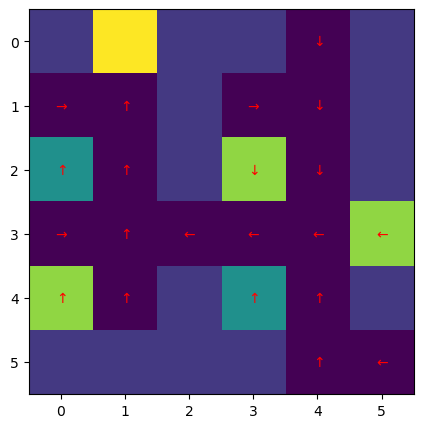

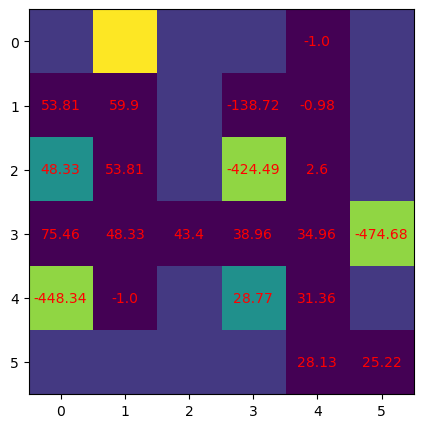

CPU times: total: 7.62 s
Wall time: 15.1 s


In [14]:
%%time
# Set seed again (if needed)
np.random.seed(randomer)
random.seed(randomer)

# Create class object for Q-learning
experiment_q_learning_1 = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment_q_learning_1.train(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = max_epsilon, decay_rate = decay_rate, gamma = gamma, alpha = alpha, policy = policy)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment.get_graphics().draw_policy(final_policy)
vacuum_environment.get_graphics().draw_value(final_values[-1])

### Evaluate Different Parameters 1 ($\epsilon$-Greedy)

Using our new parameters, we obtain another sub-optimal policy after 10000 episodes (see the drawn policy overlay). This time, the agent fails to reach both carpets, but reaches the terminal state.

We can display the final reward after each episode and the number of steps during that episode as a plot, sharing the same x-axis. There is clear convergence to the sub-optimal policy. The agent evaluation also explains a mean reward of 59.1 and standard deviation of 7.105427e-15 (or zero) on 10000 episodes (after agent training). The agent begins at the same state and follows the same policy, so the standard deviation is to be expected.

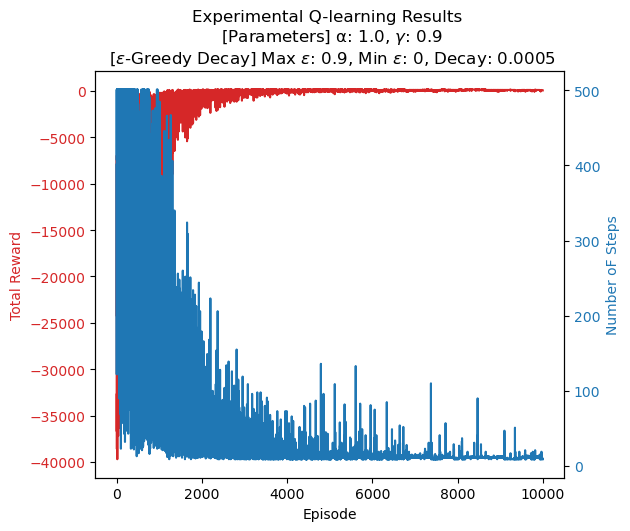

In [15]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color = "tab:red")
ax1.plot(total_rewards, color = "tab:red")
ax1.tick_params(axis = "y", labelcolor = "tab:red")

ax2 = ax1.twinx()

ax2.set_ylabel("Number oF Steps", color = "tab:blue")
ax2.plot(time_stamps, color = "tab:blue")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

fig.tight_layout()

plt.title(f"Experimental Q-learning Results \n [Parameters] α: {alpha}, $\gamma$: {gamma} \n [$\epsilon$-Greedy Decay] Max $\epsilon$: {max_epsilon}, Min $\epsilon$: {min_epsilon}, Decay: {decay_rate}")
plt.savefig("experiment_q_combined_1.pdf", bbox_inches = "tight")
plt.show()

In [16]:
%%time
# Gather statistics of agent evaluation
mean_reward, std_reward, episode_rewards = experiment_q_learning_1.evaluate(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: 59.10000000000001
Standard Deviation of Episode Rewards: 7.105427357601002e-15
CPU times: total: 1.28 s
Wall time: 1.9 s


### Exploring Different Parameters 2 ($\epsilon$-Greedy)

We experiment with different parameters for the Q-learning algorithm and policy.

It seems that higher values of $\gamma$ perform poorer, so let's try going lower instead.

We set $\gamma = 0.6$, again keeping the other parameters the same.

In [17]:
# Q-learning parameters
alpha = 1.0
gamma = 0.6
total_episodes = 10000

# Exploration-Exploitation parameters (Epsilon-Greedy, with Epsilon decay)
policy = "epsilon-greedy"
max_epsilon = 0.9
min_epsilon = 0
decay_rate = 0.0005

# Set Initial Q-table (we use zeroes, but random numbers from a uniform [0, 1) distribution work too)
Q_table = np.zeros((vacuum_environment.get_state_size(), vacuum_environment.get_action_size()))

Q-learning Final Policy and Policy Values:



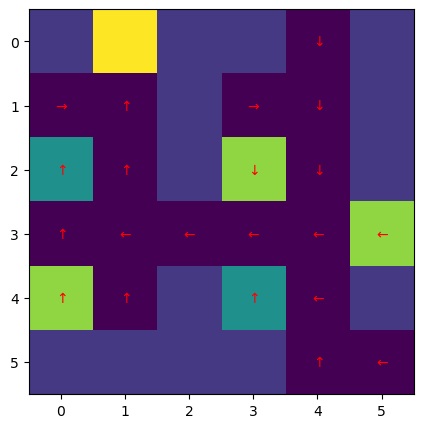

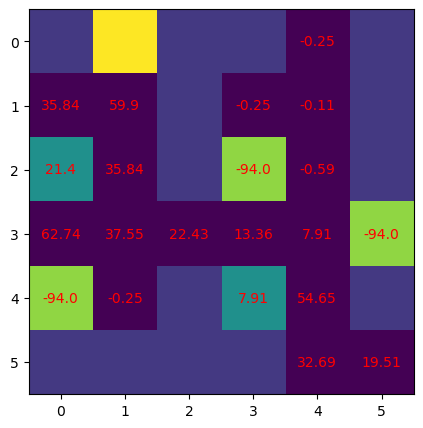

CPU times: total: 5.5 s
Wall time: 11.4 s


In [18]:
%%time
# Set seed again (if needed)
np.random.seed(randomer)
random.seed(randomer)

# Create class object for Q-learning
experiment_q_learning_2 = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment_q_learning_2.train(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = max_epsilon, decay_rate = decay_rate, gamma = gamma, alpha = alpha, policy = policy)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment.get_graphics().draw_policy(final_policy)
vacuum_environment.get_graphics().draw_value(final_values[-1])

### Evaluate Different Parameters 2 ($\epsilon$-Greedy)

Using our new parameters, we now obtain an optimal policy after 10000 episodes (see the drawn policy overlay). The agent visits both carpets and the terminal state.

We can display the final reward after each episode and the number of steps during that episode as a plot, sharing the same x-axis. There is clear convergence to the sub-optimal policy. The agent evaluation also explains a mean reward of 158.9 and standard deviation of 2.84217e-14 (or zero) on 10000 episodes (after agent training). The agent begins at the same state and follows the same policy, so the standard deviation is to be expected.

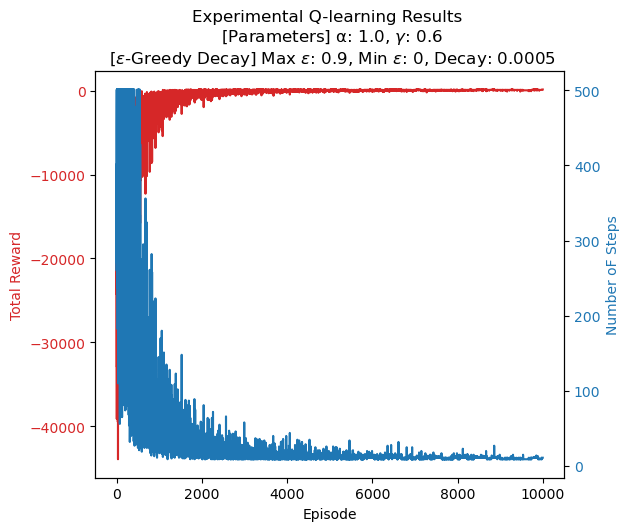

In [19]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color = "tab:red")
ax1.plot(total_rewards, color = "tab:red")
ax1.tick_params(axis = "y", labelcolor = "tab:red")

ax2 = ax1.twinx()

ax2.set_ylabel("Number oF Steps", color = "tab:blue")
ax2.plot(time_stamps, color = "tab:blue")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

fig.tight_layout()

plt.title(f"Experimental Q-learning Results \n [Parameters] α: {alpha}, $\gamma$: {gamma} \n [$\epsilon$-Greedy Decay] Max $\epsilon$: {max_epsilon}, Min $\epsilon$: {min_epsilon}, Decay: {decay_rate}")
plt.savefig("experiment_q_combined_2.pdf", bbox_inches = "tight")
plt.show()

In [20]:
%%time
# Gather statistics of agent evaluation
mean_reward, std_reward, episode_rewards = experiment_q_learning_2.evaluate(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: 158.90000000000003
Standard Deviation of Episode Rewards: 2.842170943040401e-14
CPU times: total: 1.47 s
Wall time: 2.36 s


### Exploring Different Policies 1 (Upper Confidence Bound)

We experiment with different parameters for the Q-learning algorithm and policy.

We have a set of optimal Q-learning parameters now, so let's reuse these for our new upper confidence bound policy.

The only change here is the policy, and we use exploration parameter $c = 1$ in the formula for the upper confidence bound below:

$$UCB_{t}(a) = Q_{t}(a) + c \sqrt{\frac{\ln(t)}{N_{t}(a)}}$$

where $N_{t}(a)$ is the number of times action $a$ has been selected up to time $t$ and $Q_{t}(a)$ is the action-value estimate for action $a$ at time step $t$.t

In [21]:
# Q-learning parameters
alpha = 1.0
gamma = 0.6
total_episodes = 100

# Exploration-Exploitation parameters (UCB)
policy = "ucb"
const = 1

# Set Initial Q-table (we use zeroes, but random numbers from a uniform [0, 1) distribution work too)
Q_table = np.zeros((vacuum_environment.get_state_size(), vacuum_environment.get_action_size()))

Q-learning Final Policy and Policy Values:



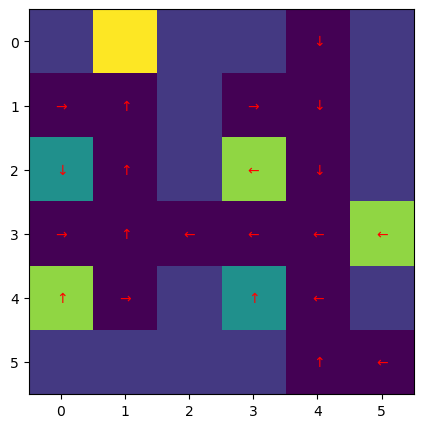

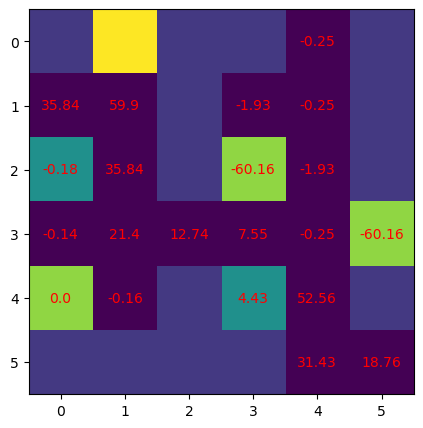

CPU times: total: 281 ms
Wall time: 554 ms


In [22]:
%%time
# Set seed again (if needed)
np.random.seed(randomer)
random.seed(randomer)

# Create class object for Q-learning
experiment_q_learning_3 = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment_q_learning_3.train(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes, const = const, gamma = gamma, alpha = alpha, policy = policy)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment.get_graphics().draw_policy(final_policy)
vacuum_environment.get_graphics().draw_value(final_values[-1])

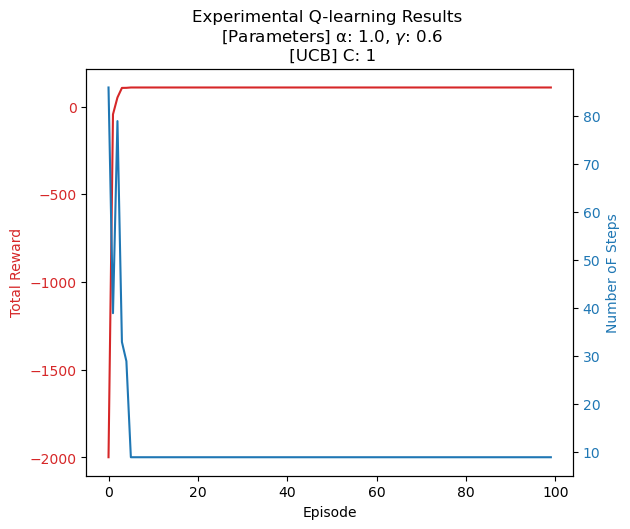

In [23]:
fig, ax1 = plt.subplots() #figsize = (12, 6)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color = "tab:red")
ax1.plot(total_rewards, color = "tab:red")
ax1.tick_params(axis = "y", labelcolor = "tab:red")

ax2 = ax1.twinx()

ax2.set_ylabel("Number oF Steps", color = "tab:blue")
ax2.plot(time_stamps, color = "tab:blue")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

fig.tight_layout()

plt.title(f"Experimental Q-learning Results \n [Parameters] α: {alpha}, $\gamma$: {gamma} \n [UCB] C: {const}")
plt.savefig("experiment_q_combined_3.pdf", bbox_inches = "tight")
plt.show()

In [24]:
%%time
# Gather statistics of agent evaluation
mean_reward, std_reward, episode_rewards = experiment_q_learning_3.evaluate(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: 109.1
Standard Deviation of Episode Rewards: 0.0
CPU times: total: 31.2 ms
Wall time: 33 ms


### Exploring Different Policies 1 (Softmax)

We experiment with different parameters for the Q-learning algorithm and policy.

We have a set of optimal Q-learning parameters now, so let's reuse these for our new softmax policy.

The only change here is the policy, and we use exploration parameter $\tau = 1$ in the formula for the softmax policy below:

$$\pi(a|s) = \frac{e^{\frac{Q(s, a)}{\tau}}}{\sum_{b} e^{\frac{Q(s, b)}{\tau}}}.$$.

In [25]:
# Q-learning parameters
alpha = 1.0
gamma = 0.6
total_episodes = 10000

# Exploration-Exploitation parameters (Softmax)
policy = "softmax"
tau = 1

# Set Initial Q-table (we use zeroes, but random numbers from a uniform [0, 1) distribution work too)
Q_table = np.zeros((vacuum_environment.get_state_size(), vacuum_environment.get_action_size()))

Q-learning Final Policy and Policy Values:



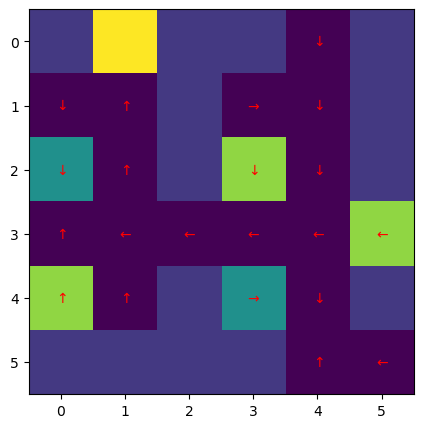

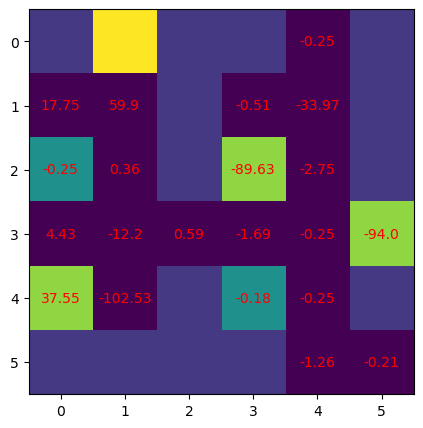

CPU times: total: 1min 34s
Wall time: 2min 36s


In [26]:
%%time
# Set seed again (if needed)
np.random.seed(randomer)
random.seed(randomer)

# Create class object for Q-learning
experiment_q_learning_4 = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment_q_learning_4.train(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes, gamma = gamma, alpha = alpha, tau = tau, policy = policy)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment.get_graphics().draw_policy(final_policy)
vacuum_environment.get_graphics().draw_value(final_values[-1])

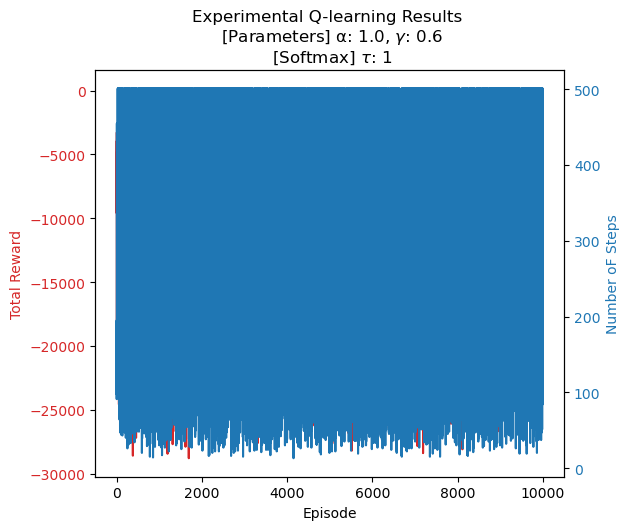

In [27]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color = "tab:red")
ax1.plot(total_rewards, color = "tab:red")
ax1.tick_params(axis = "y", labelcolor = "tab:red")

ax2 = ax1.twinx()

ax2.set_ylabel("Number oF Steps", color = "tab:blue")
ax2.plot(time_stamps, color = "tab:blue")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

fig.tight_layout()

plt.title(f"Experimental Q-learning Results \n [Parameters] α: {alpha}, $\gamma$: {gamma} \n [Softmax] $\u03C4$: {tau}")
plt.savefig("experiment_q_combined_4.pdf", bbox_inches = "tight")
plt.show()

In [28]:
%%time
# Gather statistics of agent evaluation
mean_reward, std_reward, episode_rewards = experiment_q_learning_4.evaluate(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: -50.10000000000045
Standard Deviation of Episode Rewards: 7.105427357601002e-15
CPU times: total: 29 s
Wall time: 1min


### Parameter Search

We can plot the results of using different parameters together.

In [29]:
def default_reward_parameter_lookup(env, alphas = [1.0], gammas = [0.6], epsilons = [0.9], total_episodes = 10000, min_epsilon = 0, max_epsilon = 0.9, decay_rate = 0.0005, const = 1, policy = "epsilon-greedy", identity = "no1"):
    for alpha in alphas:
        for gamma in gammas:
            for epsilon in epsilons:
                # Set Initial Q-table
                Q_table = np.zeros((env.get_state_size(), env.get_action_size()))

                # Set seed again (if needed)
                np.random.seed(randomer)
                random.seed(randomer)

                # Create class object for Q-learning
                experiment = Q_Learner()

                # Train an agent on the environment through Q-learning
                final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment.train(env = env, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = epsilon, decay_rate = decay_rate, const = const, gamma = gamma, alpha = alpha, policy = policy)

                # Plot rewards
                if policy == "epsilon-greedy":
                    plt.plot(total_rewards, label = f"α: {alpha}, $\gamma$: {gamma}, $\epsilon$: {epsilon}")
                
                elif policy == "ucb":
                    plt.plot(total_rewards, label = f"α: {alpha}, $\gamma$: {gamma}, $c$: {const}")

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    #plt.ylim((-10000, 300))
    plt.title("Total Reward for Different Parameters")
    plt.legend(bbox_to_anchor = (1.0, 1.0), loc = "upper left")
    plt.savefig(f"different_parameters_{identity}.pdf", bbox_inches = "tight")
    plt.show()

# Define a function to calculate moving average
def moving_average(data, window_size = 100):
    return np.convolve(data, np.ones(window_size), "valid") / window_size

def moving_average_parameter_lookup(env, alphas = [1.0], gammas = [0.6], epsilons = [0.9], total_episodes = 10000, min_epsilon = 0, max_epsilon = 0.9, decay_rate = 0.0005, const = 1, policy = "epsilon-greedy", window_size = 100, identity = "no1"):
    for alpha in alphas:
        for gamma in gammas:
            for epsilon in epsilons:
                # Set Initial Q-table
                Q_table = np.zeros((env.get_state_size(), env.get_action_size()))

                # Set seed again (if needed)
                np.random.seed(randomer)
                random.seed(randomer)

                # Create class object for Q-learning
                experiment = Q_Learner()
        
                # Train an agent on the environment through Q-learning
                final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment.train(env = env, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = epsilon, decay_rate = decay_rate, const = const, gamma = gamma, alpha = alpha, policy = policy)

                # Calculate moving average of rewards
                moving_avg_rewards = moving_average(total_rewards, window_size)
        
                # Plot moving average rewards
                if policy == "epsilon-greedy":
                    plt.plot(moving_avg_rewards, label = f"α: {alpha}, $\gamma$: {gamma}, $\epsilon$: {epsilon}")
                
                elif policy == "ucb":
                    plt.plot(moving_avg_rewards, label = f"α: {alpha}, $\gamma$: {gamma}, $c$: {const}")

                # Gather statistics of agent evaluation
                mean_reward, std_reward, episode_rewards = experiment.evaluate(env = env, Q_table = Q_table, total_episodes = total_episodes)
                if policy == "epsilon-greedy": 
                    print(f"### α: {alpha}, $\gamma$: {gamma}, $\epsilon$: {epsilon} ###")

                elif policy == "ucb":
                    print(f"### α: {alpha}, $\gamma$: {gamma}, $c$: {const} ###")
                print("Mean of Episode Rewards:", mean_reward)
                print("Standard Deviation of Episode Rewards:", std_reward)

    plt.xlabel("Episode")
    plt.ylabel("Moving Average Total Reward")
    #plt.ylim((-10000, 300))
    plt.title(f"{window_size}-Moving Average Total Reward for Different Parameters")
    plt.legend(bbox_to_anchor = (1.0, 1.0), loc = "upper left")
    plt.savefig(f"moving_average_rewards_{identity}.pdf", bbox_inches = "tight")
    plt.show()

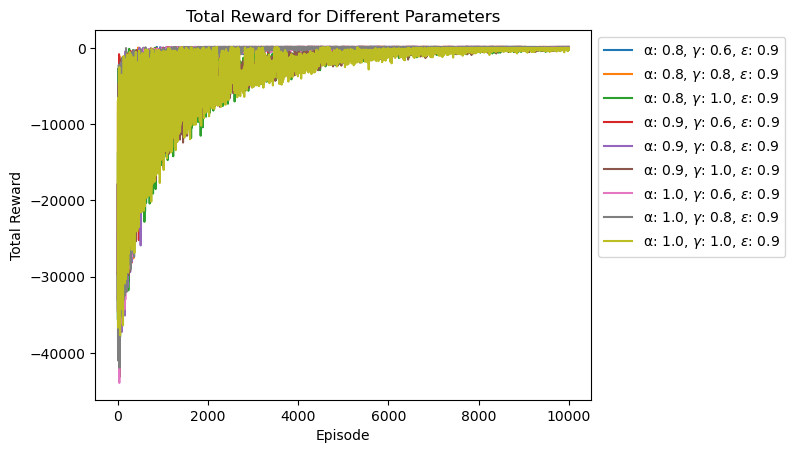

### α: 0.8, $\gamma$: 0.6, $\epsilon$: 0.9 ###
Mean of Episode Rewards: 158.90000000000003
Standard Deviation of Episode Rewards: 2.842170943040401e-14
### α: 0.8, $\gamma$: 0.8, $\epsilon$: 0.9 ###
Mean of Episode Rewards: 158.90000000000003
Standard Deviation of Episode Rewards: 2.842170943040401e-14
### α: 0.8, $\gamma$: 1.0, $\epsilon$: 0.9 ###
Mean of Episode Rewards: -50.10000000000045
Standard Deviation of Episode Rewards: 7.105427357601002e-15
### α: 0.9, $\gamma$: 0.6, $\epsilon$: 0.9 ###
Mean of Episode Rewards: 109.09999999999998
Standard Deviation of Episode Rewards: 1.4210854715202004e-14
### α: 0.9, $\gamma$: 0.8, $\epsilon$: 0.9 ###
Mean of Episode Rewards: 158.90000000000003
Standard Deviation of Episode Rewards: 2.842170943040401e-14
### α: 0.9, $\gamma$: 1.0, $\epsilon$: 0.9 ###
Mean of Episode Rewards: -0.10000000000044161
Standard Deviation of Episode Rewards: 1.3877787807814457e-17
### α: 1.0, $\gamma$: 0.6, $\epsilon$: 0.9 ###
Mean of Episode Rewards: 158.90000000

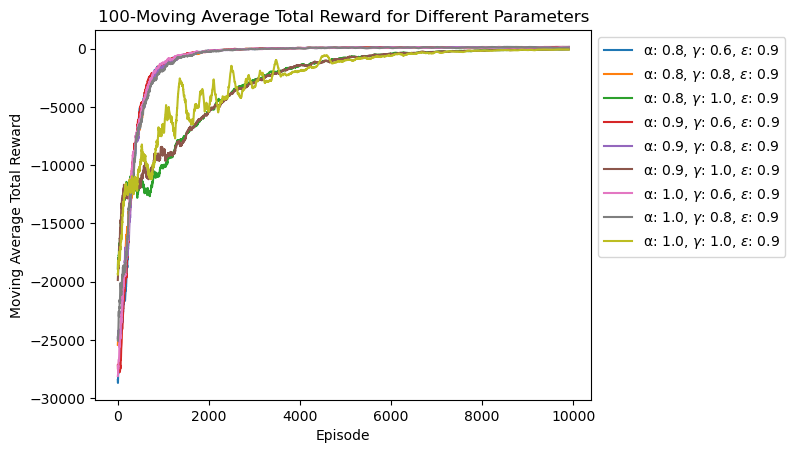

CPU times: total: 7min 36s
Wall time: 17min 14s


In [30]:
%%time

alphas = [0.8, 0.9, 1.0]
gammas = [0.6, 0.8, 1.0]
epsilons = [0.9]

default_reward_parameter_lookup(vacuum_environment, alphas, gammas, epsilons, identity = "no1")
moving_average_parameter_lookup(vacuum_environment, alphas, gammas, epsilons, identity = "no1")

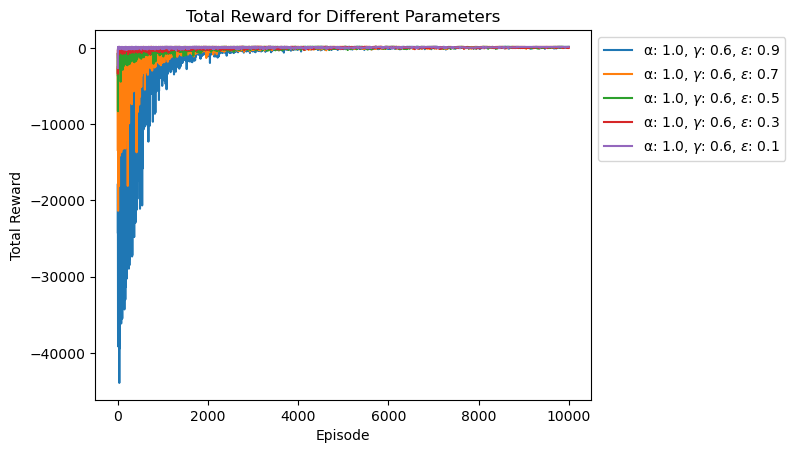

### α: 1.0, $\gamma$: 0.6, $\epsilon$: 0.9 ###
Mean of Episode Rewards: 158.90000000000003
Standard Deviation of Episode Rewards: 2.842170943040401e-14
### α: 1.0, $\gamma$: 0.6, $\epsilon$: 0.7 ###
Mean of Episode Rewards: 109.09999999999998
Standard Deviation of Episode Rewards: 1.4210854715202004e-14
### α: 1.0, $\gamma$: 0.6, $\epsilon$: 0.5 ###
Mean of Episode Rewards: 158.90000000000003
Standard Deviation of Episode Rewards: 2.842170943040401e-14
### α: 1.0, $\gamma$: 0.6, $\epsilon$: 0.3 ###
Mean of Episode Rewards: 108.90000000000002
Standard Deviation of Episode Rewards: 2.842170943040401e-14
### α: 1.0, $\gamma$: 0.6, $\epsilon$: 0.1 ###
Mean of Episode Rewards: 158.90000000000003
Standard Deviation of Episode Rewards: 2.842170943040401e-14


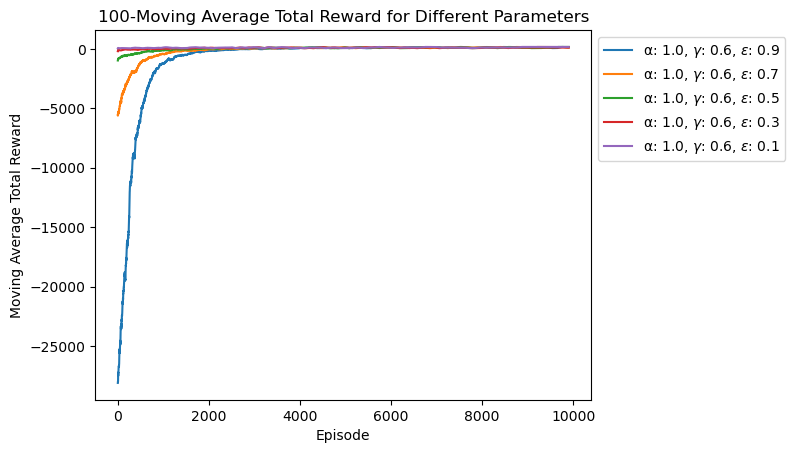

CPU times: total: 32.1 s
Wall time: 1min 12s


In [31]:
%%time

alphas = [1.0]
gammas = [0.6]
epsilons = [0.9, 0.7, 0.5, 0.3, 0.1]

default_reward_parameter_lookup(vacuum_environment, alphas, gammas, epsilons, total_episodes = 10000, identity = "no2")
moving_average_parameter_lookup(vacuum_environment, alphas, gammas, epsilons, total_episodes = 10000, identity = "no2")

### Changing the Reward Distribution

The only change is the reward matrix.

In [32]:
class Gridworld_new(object):
    """
    Class to create an environment, which is normally referred to as a Gridworld. We construct our robot vacuum cleaner environment using this class.
    It requires hyperparameters to be input, which are the grid size (shape), locations of any obstacles, locations of any walls, locations of terminal states (absorbing states),
    the reward obtained from visiting these terminal states, possible starting locations of the agent, the default reward for taking an action, and finally
    the maximum number of steps the agent can take before the episode ends.
    
    The class is inspired and based on the coursework from a Reinforcement Learning module at Imperial College London, which was given to students to help with their assignments.
    That class can be found here: https://github.com/LorenzoStigliano/imperial-reinforcement-learning/blob/master/Coursework/CW1/coursework_1_maze.ipynb.
    """
    # Initialise Gridworld object (to create the environment)
    def __init__(self, shape, obstacle_locs, wall_locs, non_terminal_reward_locs, terminal_locs, terminal_rewards, starting_locs, colour, max_time):
        # Define variables for use within the object
        self._shape = shape
        self._obstacle_locs = obstacle_locs
        self._wall_locs = wall_locs
        self._non_terminal_reward_locs = non_terminal_reward_locs
        self._terminal_locs = terminal_locs
        self._terminal_rewards = terminal_rewards
        self._starting_locs = starting_locs
        self._colour = colour
        self._max_time = max_time
        
        # Build the environment
        self._build_Gridworld()

    # Method to build the Gridworld environment
    def _build_Gridworld(self):
        # Four total actions
        self._action_size = 4
        # Up, right, down, left (North, East, South, West)
        self._direction_names = ["N", "E", "S", "W"]
        self._locations = []

        # Populate list of locations based on grid size and obstacle placements
        for i in range(self._shape[0]):
            for j in range(self._shape[1]):
                loc = (i, j)
                if self._is_location(loc):
                    # Adding the state to locations
                    self._locations.append(loc)

        # Number of locations
        self._state_size = len(self._locations)

        # Each line is a state, with each column a unique action/direction (N, E, S, W)
        self._neighbours = np.zeros((self._state_size, 4)) 

        # Loop over states
        for state in range(self._state_size):
            # Get location of state on grid
            loc = self._get_loc_from_state(state)

            # Moving North
            neighbour = (loc[0] - 1, loc[1])
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("N")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("N")] = state

            # Moving East
            neighbour = (loc[0], loc[1] + 1)
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("E")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("E")] = state

            # Moving South
            neighbour = (loc[0] + 1, loc[1])
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("S")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("S")] = state
            
            # Moving West
            neighbour = (loc[0], loc[1] - 1)
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("W")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("W")] = state

        # Terminal states
        self._terminal = np.zeros((1, self._state_size))
        for a in self._terminal_locs:
            terminal_state = self._get_state_from_loc(a)
            self._terminal[0, terminal_state] = 1

        # Construct transition matrix
        self._T = np.zeros((self._state_size, self._state_size, self._action_size))
        # Loop over every action/direction
        for action in range(self._action_size):
            for outcome in range(4):
                if action == outcome:
                    prob = 1
                else:
                    prob = 0
                for prior_state in range(self._state_size):
                    if not self._terminal[0, prior_state]:
                        post_state = self._neighbours[prior_state, outcome]
                        post_state = int(post_state)
                        self._T[prior_state, post_state, action] += prob

        # Construct reward matrix
        self._construct_R()
        
        # Create visualiser for the Gridworld environment
        self._graphics = Visualiser(self._shape, self._locations, self._colour, self._obstacle_locs, self._wall_locs, self._non_terminal_reward_locs, self._terminal_locs, self._terminal_rewards, self._terminal)
        # Reset the environment
        self.reset()

    # Method to check if a location is valid (reachable)
    def _is_location(self, loc):
        if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0] - 1 or loc[1] > self._shape[1] - 1):
            return False
        elif (loc in self._obstacle_locs):
            return True
        elif (loc in self._wall_locs):
            return False
        elif (loc in self._non_terminal_reward_locs):
            return True
        else:
            return True

    # Method to construct the reward matrix
    def _construct_R(self):
        # Reward matrix
        # Fill matrix with zeroes
        self._R = np.zeros((self._state_size, self._state_size, self._action_size))
        # Assign rewards of terminal states
        for i in range(len(self._terminal_rewards)):
            post_state = self._get_state_from_loc(self._terminal_locs[i])
            # Assign reward for visiting terminal state
            self._R[:, post_state, :] = self._terminal_rewards[i]

        # Assign negative reward for moving into obstacles (cables)
        for obstacle_loc in self._obstacle_locs:
            obstacle_state = self._get_state_from_loc(obstacle_loc)
            # Negative reward for all actions leading to an obstacle
            self._R[:, obstacle_state, :] = -1
            # Negative reward for moving from obstacle state to itself
            self._R[obstacle_state, obstacle_state, :] = -1

        # Get non-obstacle locations and non-terminal locations
        self._normal_locs = [(i, j) for i in range(self._shape[0]) for j in range(self._shape[1]) if (i, j) not in self._obstacle_locs and (i, j) not in self._wall_locs and (i, j) not in self._non_terminal_reward_locs and not self._terminal[0, self._get_state_from_loc((i, j))]]

        # Assign reward for moving to a non-obstacle (some areas not used)
        for normal_loc in self._normal_locs:
            normal_state = self._get_state_from_loc(normal_loc)
            # Positive reward for all actions leading to a new location
            #self._R[:, normal_state, :] = 0
            # Negative reward for moving to itself (the agent tried to move off the grid or to a wall/furniture location)
            self._R[normal_state, normal_state, :] = 0

        # Assign positive reward for moving to a carpet (all of them are initially not cleaned)
        for non_terminal_reward_loc in self._non_terminal_reward_locs:
            non_terminal_reward_loc_state = self._get_state_from_loc(non_terminal_reward_loc)
            # Positive reward for all actions leading to a new non-cleaned location
            self._R[:, non_terminal_reward_loc_state, :] = 1
            # Negative reward for moving to itself (the agent tried to move off the grid or to a wall/furniture location)
            self._R[non_terminal_reward_loc_state, non_terminal_reward_loc_state, :] = 0
        
        # Save reward matrix in memory, as it will be changed later during the episode
        self._R_old = self._R
        return self._R_old, self._R

    # Method to get state index from location
    def _get_state_from_loc(self, loc):
        return self._locations.index(tuple(loc))

    # Method to get location from state index
    def _get_loc_from_state(self, state):
        return self._locations[state]

    # Method to return the state transition matrix
    def get_T(self):
        return self._T

    # Method to return the reward matrix
    def get_R(self):
        return self._R

    # Method to return terminal state indicators
    def get_terminal(self):
        return self._terminal

    # Method to return the visualiser object
    def get_graphics(self):
        return self._graphics

    # Method to return the action size
    def get_action_size(self):
        return self._action_size

    # Method to return the state size
    def get_state_size(self):
        return self._state_size

    # Method to reset the environment
    def reset(self):
        # Define/reset variables for use within the object (during agent training)
        self._t = 0
        self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
        self._reward = 0
        self._R = self._construct_R()[0]
        self._done = False
        self._visited = set()
        self._visited.add(self._state)
        self._visited_carpets = set()
        return self._t, self._state, self._reward, self._done

    # Method to take a step in the environment
    def step(self, action):
        if self._done:
            print("Please reset the environment")
            return self._t, self._state, self._reward, self._done
        
        # Determine the next state based on the action taken
        new_state = np.argmax(self._T[self._state, :, action])

        self._reward = self._R[self._state, new_state, action]
        
        # Adjust reward matrix if new state reached
        obstacle_locations = [obstacle_state for obstacle_state in list(map(self._get_state_from_loc, self._obstacle_locs))]
        non_terminal_reward_locations = [non_terminal_reward for non_terminal_reward in list(map(self._get_state_from_loc, self._non_terminal_reward_locs))]

        # If the new state is one of the extra reward locations ('non_terminal_reward_locations')
        if new_state in non_terminal_reward_locations:
            # Check if the carpet has been visited before
            if new_state not in self._visited_carpets:
                self._visited_carpets.add(new_state)  # Add the carpet location to the set of visited carpets
                self._R[:, new_state, :] = 0
            else:
                self._reward = 0  # If the carpet has been visited before, set the reward to zero

            self._visited.add(new_state)

        # Negative reward per time point
        self._reward += 0
        
        # Setting new t, state and done
        self._t += 1
        self._done = self._terminal[0, new_state] or self._t > self._max_time
        self._state = new_state
        
        return self._t, self._state, self._reward, self._done

### New Environment Hyperparameters

The only change is the reward matrix.

In [33]:
# Define environment hyperparameters, see report for more detail
shape = (6, 6)
obstacle_locs = [(2, 3), (3, 5), (4, 0)]
wall_locs = [(0, 0), (0, 2), (0, 3), (0, 5), (1, 2), (1, 5), (2, 2), (2, 5), (4, 2), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3)]
non_terminal_reward_locs = [(2, 0), (4, 3)]
terminal_locs = [(0, 1)]
terminal_rewards = [1]
starting_locs = [(5, 5)]
colour = -20
max_time = 500

### Define New Environment

The only change is the reward matrix.

Robot Vacuum Cleaner Environment:



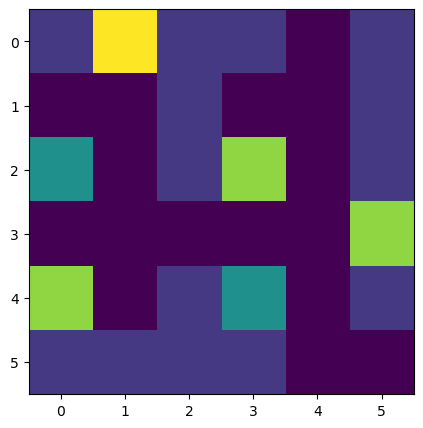

CPU times: total: 141 ms
Wall time: 227 ms


In [34]:
%%time
# Create new robot vacuum cleaner environment
print("Robot Vacuum Cleaner Environment:\n")
vacuum_environment_new = Gridworld_new(shape = shape, obstacle_locs = obstacle_locs, wall_locs = wall_locs, non_terminal_reward_locs = non_terminal_reward_locs, terminal_locs = terminal_locs, terminal_rewards = terminal_rewards, starting_locs = starting_locs, colour = colour, max_time = max_time)

### New Reward Matrix

A Markov decision process requires a state-transition matrix and a reward matrix. We display these below, as well as the possible transition probabilities (0 or 1), and the possible reward values (-1, 0 or 1).

In [35]:
# Transition Matrix
print("Possible Transition Probabilities:", np.unique(vacuum_environment_new.get_T()))
print("Transition Matrix:\n", vacuum_environment_new.get_T())

# Reward Matrix (note that the reward for visiting a previous state changes during the episode)
print("Possible Reward Values:", np.unique(vacuum_environment_new.get_R()))
print("Initial Reward Matrix:\n", vacuum_environment_new.get_R())

Possible Transition Probabilities: [0. 1.]
Transition Matrix:
 [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [1. 1. 0. 1.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 0. 0. 1.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [0. 0. 1. 1.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 1.]
  [1. 1. 1. 0.]]]
Possible Reward Values: [-1.  0.  1.]
Initial Reward Matrix:
 [[[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0.

### Testing Previous Optimal Parameters and Policy

In [36]:
# Q-learning parameters
alpha = 1.0
gamma = 0.6
total_episodes = 10000

# Exploration-Exploitation parameters (Epsilon-Greedy, with Epsilon decay)
policy = "epsilon-greedy"
max_epsilon = 0.9
min_epsilon = 0
decay_rate = 0.0005

# Set Initial Q-table (we use zeroes, but random numbers from a uniform [0, 1) distribution work too)
Q_table = np.zeros((vacuum_environment_new.get_state_size(), vacuum_environment_new.get_action_size()))

Q-learning Final Policy and Policy Values:



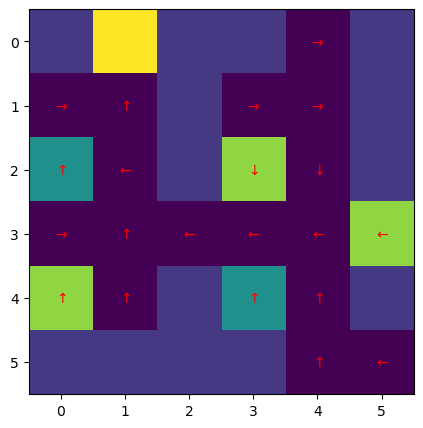

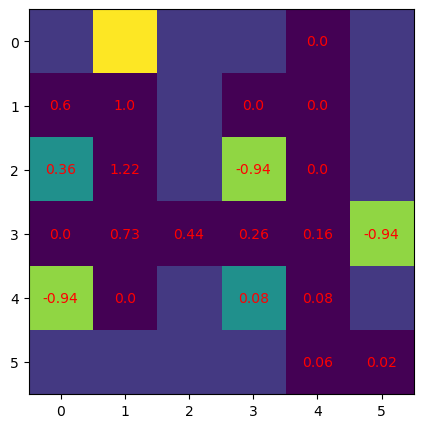

In [37]:
%%time

# Set seed again (if needed)
np.random.seed(randomer)
random.seed(randomer)

# Create class object for Q-learning
experiment_q_combined_new_reward = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment_q_combined_new_reward.train(env = vacuum_environment_new, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = max_epsilon, decay_rate = decay_rate, gamma = gamma, alpha = alpha, policy = policy)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment_new.get_graphics().draw_policy(final_policy)
vacuum_environment_new.get_graphics().draw_value(final_values[-1])

### Evaluating Parameters and Policy on New Environment

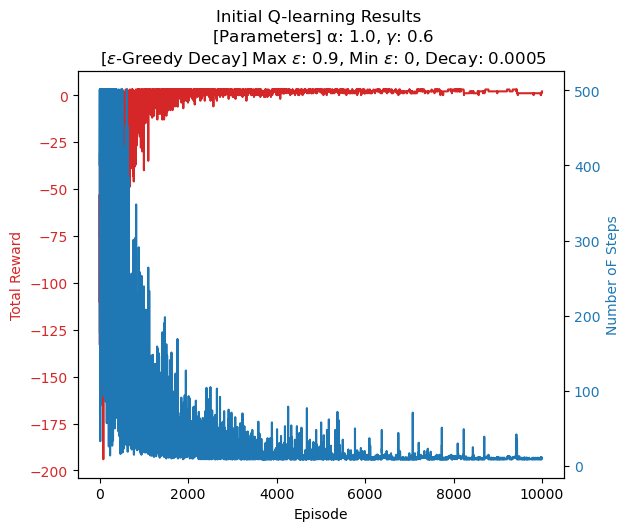

In [38]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color = "tab:red")
ax1.plot(total_rewards, color = "tab:red")
ax1.tick_params(axis = "y", labelcolor = "tab:red")

ax2 = ax1.twinx()

ax2.set_ylabel("Number oF Steps", color = "tab:blue")
ax2.plot(time_stamps, color = "tab:blue")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

fig.tight_layout()

plt.title(f"Initial Q-learning Results \n [Parameters] α: {alpha}, $\gamma$: {gamma} \n [$\epsilon$-Greedy Decay] Max $\epsilon$: {max_epsilon}, Min $\epsilon$: {min_epsilon}, Decay: {decay_rate}")
plt.savefig("experiment_q_combined_new_reward.pdf", bbox_inches = "tight")
plt.show()

In [39]:
%%time
# Gather statistics of agent evaluation
mean_reward, std_reward, episode_rewards = experiment_q_combined_new_reward.evaluate(env = vacuum_environment_new, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: 2.0
Standard Deviation of Episode Rewards: 0.0
CPU times: total: 1.05 s
Wall time: 2.38 s


### Optimal Parameters and Policy for New Environment

In [40]:
# Q-learning parameters
alpha = 1.0
gamma = 0.2
total_episodes = 10000

# Exploration-Exploitation parameters (Epsilon-Greedy, with Epsilon decay)
policy = "epsilon-greedy"
max_epsilon = 0.9
min_epsilon = 0
decay_rate = 0.0005

# Set Initial Q-table (we use zeroes, but random numbers from a uniform [0, 1) distribution work too)
Q_table = np.zeros((vacuum_environment_new.get_state_size(), vacuum_environment_new.get_action_size()))

Q-learning Final Policy and Policy Values:



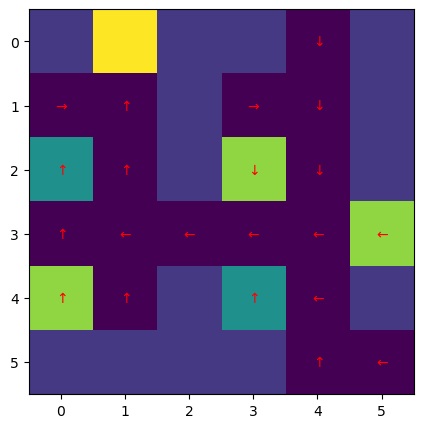

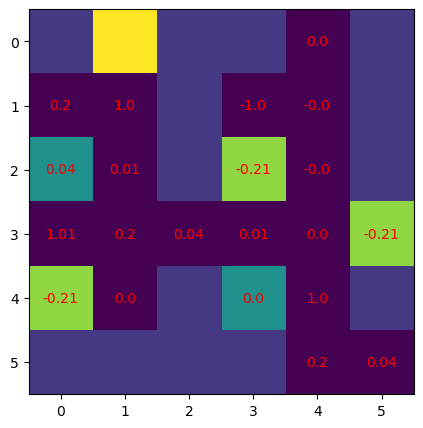

In [41]:
%%time

# Set seed again (if needed)
np.random.seed(randomer)
random.seed(randomer)

# Create class object for Q-learning
experiment_q_combined_new_reward_optimal = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, avg_change_in_Q, Q_table = experiment_q_combined_new_reward_optimal.train(env = vacuum_environment_new, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = max_epsilon, decay_rate = decay_rate, gamma = gamma, alpha = alpha, policy = policy)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment_new.get_graphics().draw_policy(final_policy)
vacuum_environment_new.get_graphics().draw_value(final_values[-1])

### Evaluating New Parameters and Policy for New Environment

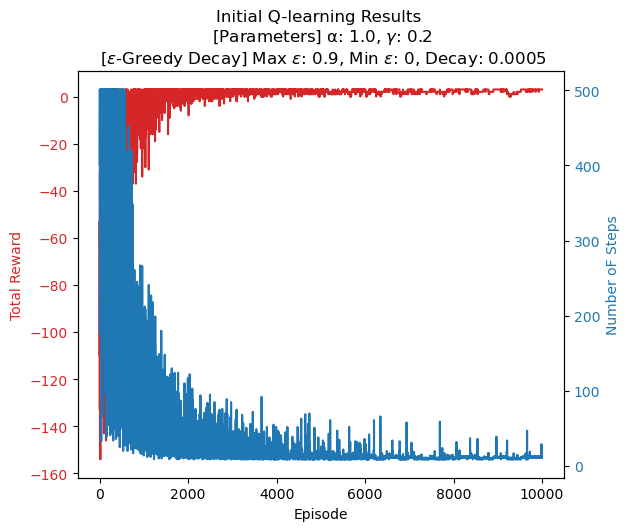

In [42]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color = "tab:red")
ax1.plot(total_rewards, color = "tab:red")
ax1.tick_params(axis = "y", labelcolor = "tab:red")

ax2 = ax1.twinx()

ax2.set_ylabel("Number oF Steps", color = "tab:blue")
ax2.plot(time_stamps, color = "tab:blue")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

fig.tight_layout()

plt.title(f"Initial Q-learning Results \n [Parameters] α: {alpha}, $\gamma$: {gamma} \n [$\epsilon$-Greedy Decay] Max $\epsilon$: {max_epsilon}, Min $\epsilon$: {min_epsilon}, Decay: {decay_rate}")
plt.savefig("experiment_q_combined_new_reward_optimal.pdf", bbox_inches = "tight")
plt.show()

In [43]:
%%time
# Gather statistics of agent evaluation
mean_reward, std_reward, episode_rewards = experiment_q_combined_new_reward_optimal.evaluate(env = vacuum_environment_new, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: 3.0
Standard Deviation of Episode Rewards: 0.0
CPU times: total: 734 ms
Wall time: 2.43 s
